In [1]:
import os
import datetime

# import boto
import sqlite3

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

# 0. Get Data 

### Scope out data directory

### TODO:
- get stock data from _s3_ using `boto3`
- also ... I should probably put a data dictionary in the dir rather than hard-coding columns here

In [3]:
stock_csv_folder = "../2016_fordham_python_seminar/stock_csvs/"

In [4]:
stock_csv_names = sorted(os.listdir(stock_csv_folder))

In [5]:
len(stock_csv_names)

500

In [6]:
stock_csv_names[:5]

['table_a.csv',
 'table_aa.csv',
 'table_aapl.csv',
 'table_abbv.csv',
 'table_abc.csv']

In [7]:
# cols = open("_data_dir.txt").readlines()

In [8]:
cols = ['date', 'time', 'open', 'high', 'low_price', 'close', 'volume']

### Look at sample of data

In [9]:
a_df = pd.read_csv(os.path.join(stock_csv_folder, stock_csv_names[0]),
                   names=cols)

In [10]:
a_df.shape

(3452, 7)

In [11]:
a_df.head()

,date,time,open,high,low_price,close,volume
0,19991118,0,42.2076,46.3820,37.4581,39.1928,4.398181e+07
1,19991119,0,39.8329,39.8885,36.9293,37.6251,1.139020e+07
2,19991122,0,38.3208,40.0091,37.1613,39.9442,4.654716e+06
3,19991123,0,39.4247,40.4729,37.3375,37.5138,4.268903e+06
4,19991124,0,37.2262,38.9052,37.1056,38.0889,3.602367e+06


In [12]:
a_df.dtypes

date           int64
time           int64
open         float64
high         float64
low_price    float64
close        float64
volume       float64
dtype: object

We see that most of the typing here looks good (no `object` / `string` representations of numeric data) but we do see that `date` is coming in as an `int` rather than a `datetime`. Why is this important? Because, as we will see later, we want our `date` column's values to look, act, and feel like _dates_, as opposed to _integers_ - after all, isn't time series data just data that's _indexed on time_?

Also, we see that the `time` column has a value of `0` in the top five rows, and we know that this is _daily_ data - is `time` relevant?

Before we get in to handling these issues, let's continue with our basic data quality checks.

In [13]:
a_df.isnull().sum()

date         0
time         0
open         0
high         0
low_price    0
close        0
volume       0
dtype: int64

In [14]:
a_df.duplicated().sum()

0

Great! No missing data, and no duplicate data.

In [15]:
a_df.date.astype(str).head()

0    19991118
1    19991119
2    19991122
3    19991123
4    19991124
Name: date, dtype: object

Now, let's handle `date`:

In [16]:
a_df.date = pd.to_datetime(a_df.date.astype(str), infer_datetime_format=True)

In [17]:
a_df.date.head()

0   1999-11-18
1   1999-11-19
2   1999-11-22
3   1999-11-23
4   1999-11-24
Name: date, dtype: datetime64[ns]

Let's check that this is a _proper_ time-series data set, i.e. we have one date for every row:

In [18]:
a_df.date.nunique() / len(a_df)

1.0

Great - we can now set this as our index, which will make many analytical techniques (plotting and joining, for example) easier:

In [19]:
a_df = a_df.set_index("date")

And, `time`:

In [20]:
a_df.time.nunique()

1

In [21]:
a_df = a_df.drop("time", axis=1)

### Problem

Get an _iterable_ of `DataFrames`, one for each stock in our dataset, with the wrangling we did above included.

In [22]:
def get_csv_path(csv_name, stock_csv_folder=stock_csv_folder):
    return os.path.join(stock_csv_folder, csv_name)

In [23]:
def get_df(csv_name, cols=cols):
    df = pd.read_csv(get_csv_path(csv_name),
                     names=cols,
                     usecols=list(filter(lambda c: c!= "time", cols)))
    
    df.date = pd.to_datetime(df.date.astype(str), infer_datetime_format=True)

    return df.set_index("date", drop=False)

In [24]:
dfs_iter = (
    get_df(
        get_csv_path(csv_name)
    ) for csv_name in stock_csv_names
)

In [25]:
# dfs_list = list(dfs_iter)

# 1. Basic Analysis: `AAPL`

### Initial look

In [26]:
aapl_df = get_df("table_aapl.csv")

In [27]:
aapl_df.shape

(3926, 6)

**Note**: we have more rows for `aapl` data than we do for `a`.

In [28]:
pd.Series(aapl_df.index).quantile([0, 1])

0.0   1998-01-02
1.0   2013-08-09
Name: date, dtype: datetime64[ns]

In [29]:
pd.Series(a_df.index).quantile([0, 1])

0.0   1999-11-18
1.0   2013-08-09
Name: date, dtype: datetime64[ns]

As expected, both `DataFrames` have same end date, but `aapl`'s data starts earlier.

In [30]:
aapl_df.isnull().sum()

date         0
open         0
high         0
low_price    0
close        0
volume       0
dtype: int64

In [31]:
aapl_df.duplicated().sum()

0

Let's take a look at the `aapl` data:

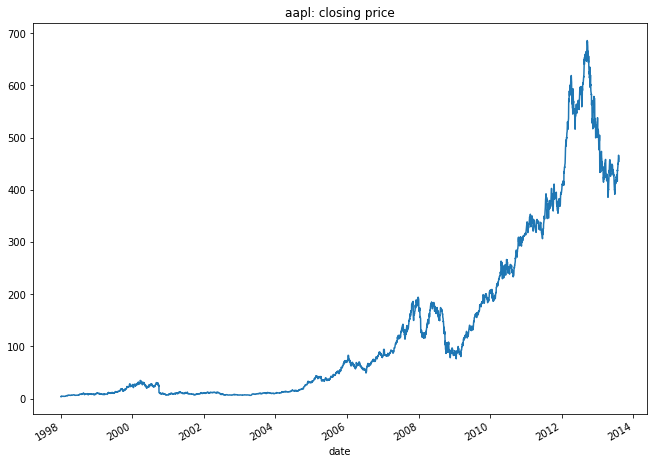

In [32]:
ax = aapl_df.close.plot(figsize=(11, 8))
t = ax.set_title("aapl: closing price")

A couple of observations on the above graph:
- the stock's price has increased over time
- there is a good bit of variability in between the start and end points

How can we get a more insight into how this stock's price is changing?

### Returns

In [33]:
aapl_df["return_gross"] = aapl_df.close.divide(aapl_df.close.shift(1))

In [34]:
aapl_df["return_simple"] = aapl_df.return_gross - 1

In [35]:
aapl_df.return_simple.describe()

count    3925.000000
mean        0.001672
std         0.029774
min        -0.518150
25%        -0.013670
50%         0.000859
75%         0.016312
max         0.183749
Name: return_simple, dtype: float64

`are the points you're making here correct??`

So our simple average daily return is about _17 basis points_, with a corresponding standard deviation of about _3 percent_. Notice that the _mean_ is higher than the _median_ (almost twice as high, in fact) - what does this mean?

The median is more resistant to _outliers_ than the mean is, so generally, if a mean is higher than a median, it means that there are outliers that exist right, or positive, of the "center" of the data - i.e. the data is _right-_ or _positive-skewed_ (especially if we have a whole _tail_ of data that stretches away from the center asymmetrically).

Let's take a look at the distribution of our simple returns:

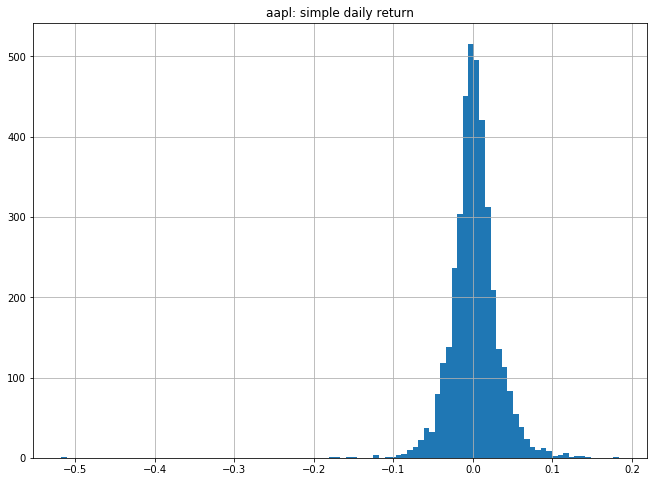

In [36]:
ax = aapl_df.return_simple.hist(figsize=(11, 8), bins=100)

# meanline = plt.axvline(aapl_df.return_simple.mean(), color="pink", linestyle="--")
# medianline = plt.axvline(aapl_df.return_simple.median(), color="yellow", linestyle="--")

t = ax.set_title("aapl: simple daily return")

In [ ]:
aapl_df.reset_index()[["date"]]

### Problem

Perform a similar analysis to what we did with `aapl.simple_returns` but do this using _volume-weighted_ returns.

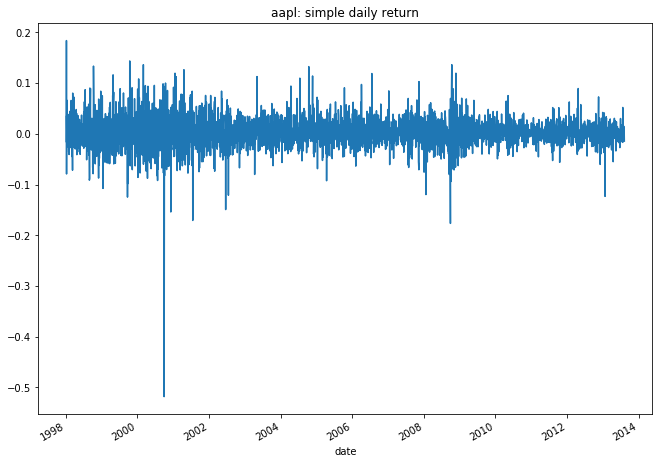

In [39]:
ax = aapl_df.return_simple.plot(figsize=(11, 8))
t = ax.set_title("aapl: simple daily return")

In [ ]:
aapl_df.

Look at the average daily returns in a given month:

In [37]:
aapl_df["month"] = aapl_df.date.apply(lambda d: d.month)

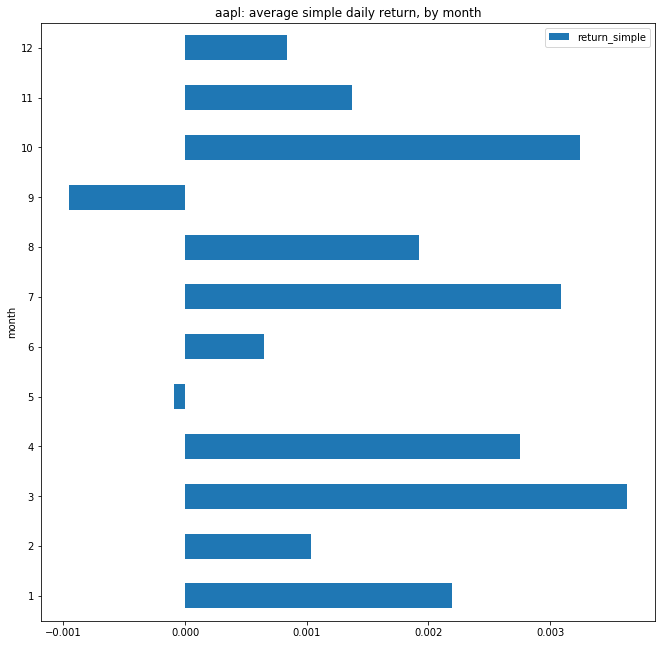

In [50]:
ax = aapl_df[["month", "return_simple"]
             ].groupby("month"
             ).mean(
             ).plot.barh(figsize=(11, 11))

t = ax.set_title("aapl: average simple daily return, by month")

### Problem

Get average _monthly_ return, and visualize.

In [51]:
aapl_df["return_simple_30_mean"] = aapl_df.return_simple.rolling(30).mean()

should you use gross here? for plotting purposes...

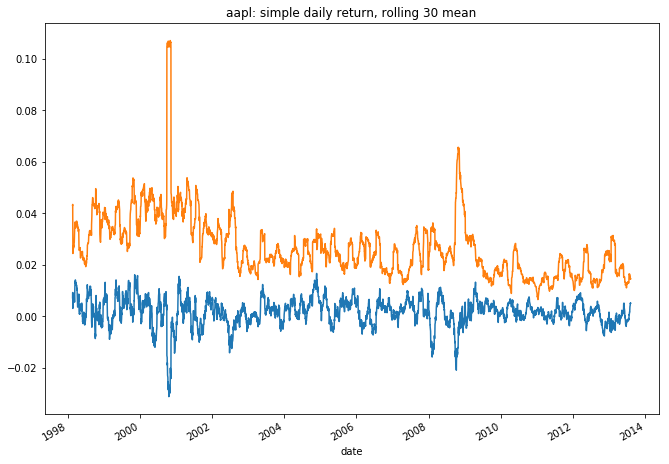

In [64]:
ax = aapl_df.return_simple_30_mean.plot(figsize=(11, 8)) /
ax = aapl_df.return_simple_30_std.plot(ax=ax)
t = ax.set_title("aapl: simple daily return, rolling 30 mean")

In [55]:
aapl_df[["return_simple_30_mean", "return_simple_30_std"]].corr()

,return_simple_30_mean,return_simple_30_std
return_simple_30_mean,1.000000,-0.325643
return_simple_30_std,-0.325643,1.000000


### Problem

Devise a procedure for looking at how return _mean vs. std_ correlation changes over time, and visualize.

In [61]:
aapl_df["return_simple_30_mean_std_corr"] = aapl_df[["return_simple_30_mean", 
                                                     "return_simple_30_std"]
                                                   ].rolling(30
                                                   ).corr(
                                                   ).unstack(
                                                   ).iloc[:, 1]

is this a solid analysis technique? I think you may have unstacked wrongly...

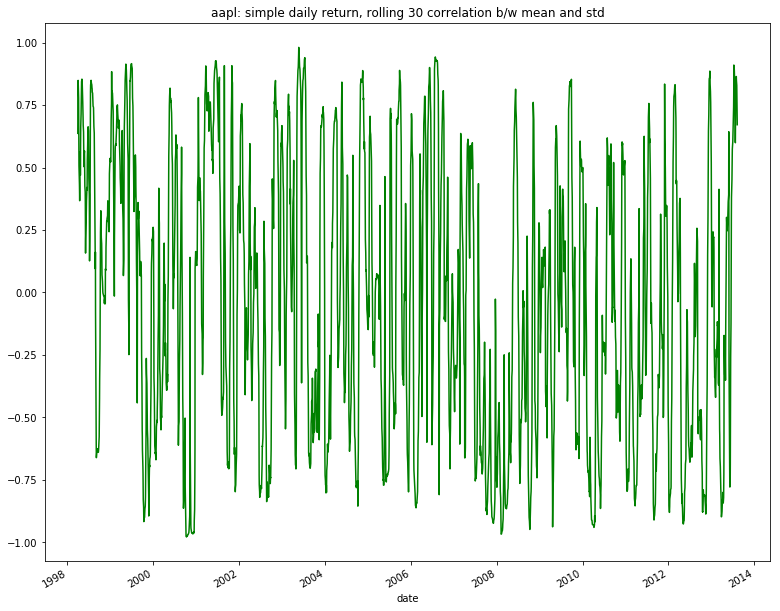

In [69]:
ax = aapl_df.return_simple_30_mean_std_corr.plot(figsize=(13, 11), color="green")
t = ax.set_title("aapl: simple daily return, rolling 30 correlation b/w mean and std")

In [51]:
aapl_df["return_simple_30_mean"] = aapl_df.return_simple.rolling(30).mean()

In [52]:
aapl_df["return_simple_30_std"] = aapl_df.return_simple.rolling(30).std()

more basic shit
- get rolling correlation right
- rolling vs. resample? can I run `pcnt_change` on a resample to get monthly return?

need regime change
- can I just use mean and std changing beyond a certain threshold?
- maybe just look this up - "regime change python"
- [paper](https://pages.uoregon.edu/jpiger/research/published-papers/piger_2009_ecss.pdf)
- [blog](https://www.quantstart.com/articles/market-regime-detection-using-hidden-markov-models-in-qstrader)

time series decomposition
- need a good example on why this technique is important
- can use prophet for this
- [svds](https://www.svds.com/avoiding-common-mistakes-with-time-series/)
- is using returns enough to avoid this? how to control for these things? ugh...